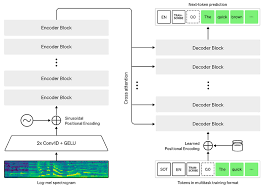

In [30]:
import pandas as pd
from jiwer import wer, cer
from eval import normalize_text
from datasets import load_dataset
import os
import glob

results_dir = '/workspace/results_librispeech_asr_dummy'
dataset = load_dataset('hf-internal-testing/librispeech_asr_dummy')
tempo_total = sum([len(audio['array'])/audio['sampling_rate'] for audio in dataset['validation']['audio']])
print("Tempo do dataset:", tempo_total, "sec") 
final_results = []


for result in glob.glob(os.path.join(results_dir, "*.csv")):
    info = pd.read_csv(result)

    ref_map = {
        item['audio']['path'].replace('.flac', ''): item['text']
        for item in dataset['validation']
    }

    # Aplica WER de forma vetorizada
    info['reference'] = info['audio_id'].map(ref_map)
    info['wer'] = info.apply(lambda row: wer(normalize_text(row['reference']), normalize_text(row['transcricao'])), axis=1)
    info['cer'] = info.apply(lambda row: cer(normalize_text(row['reference']), normalize_text(row['transcricao'])), axis=1)
    info.to_csv(result, index=False, encoding='utf-8')

    tempo_inferencia = sum(info['tempo'])
    rtf = tempo_inferencia / tempo_total
    wer_mean, wer_median, cer_mean, cer_median = info['wer'].mean(), info['wer'].median(), info['cer'].mean(), info['cer'].median()
    
    new_row = {
        'result': result.split('/')[-1].replace('.csv', ''),
        'tempo_inferencia': tempo_inferencia,
        'rtf': rtf,
        'wer_mean': wer_mean,
        'wer_median': wer_median,
        'cer_mean': cer_mean,
        'cer_median': cer_median
    }

    final_results.append(new_row)
output_dir = os.path.join(results_dir, 'final_results')
os.makedirs(output_dir, exist_ok=True)

df_final = pd.DataFrame(final_results)
df_final.to_csv(os.path.join(output_dir, 'final_results.csv'), index=False, encoding='utf-8')


Tempo do dataset: 481.03487500000006 sec


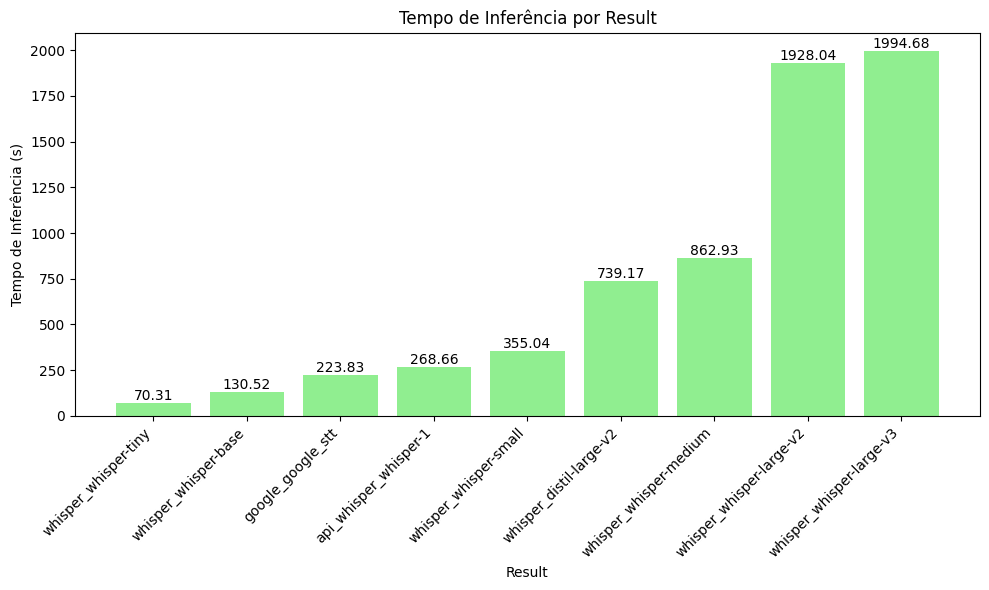

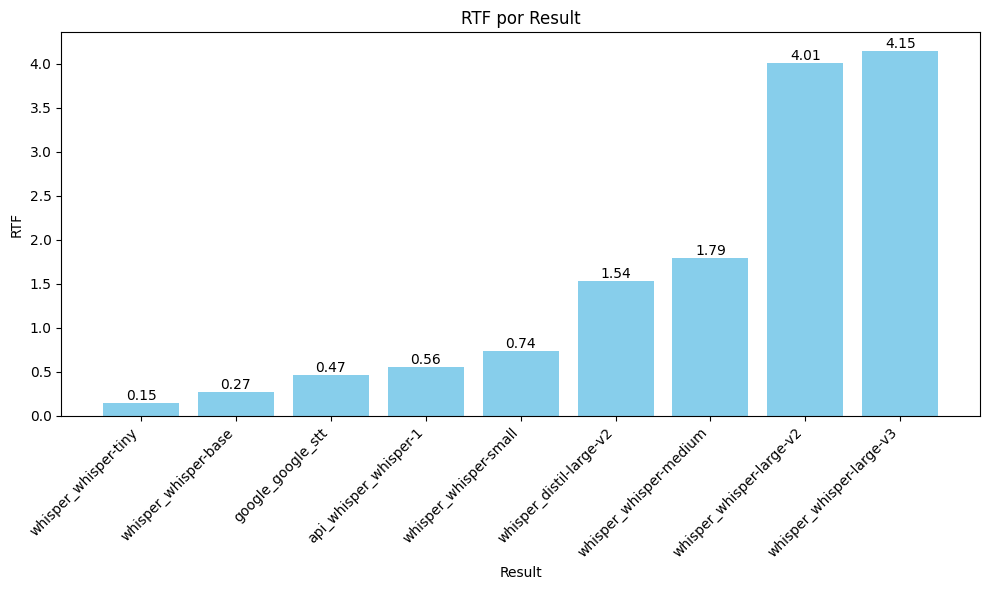

In [41]:

# Gráfico para Tempo de Inferência
df_final_sorted_tempo = df_final.sort_values(by='tempo_inferencia', ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.bar(df_final_sorted_tempo['result'], df_final_sorted_tempo['tempo_inferencia'], color='lightgreen')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Result')
plt.ylabel('Tempo de Inferência (s)')
plt.title('Tempo de Inferência por Result')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Gráfico para RTF
df_final_sorted_rtf = df_final.sort_values(by='rtf', ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.bar(df_final_sorted_rtf['result'], df_final_sorted_rtf['rtf'], color='skyblue')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Result')
plt.ylabel('RTF')
plt.title('RTF por Result')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

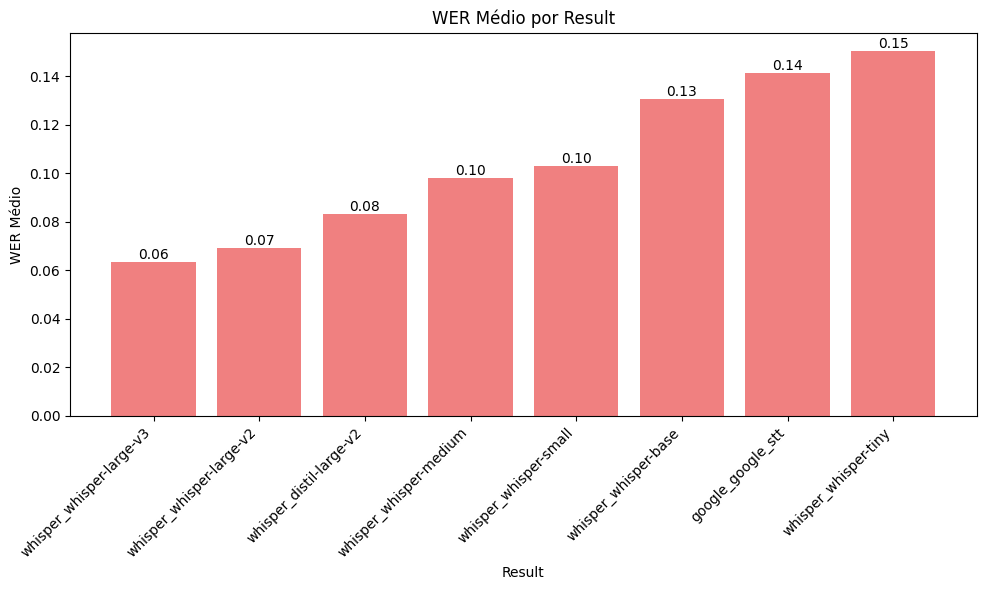

In [47]:
# Gráfico para WER médio
df_final_sorted_wer = df_final.sort_values(by='wer_mean', ascending=True)
df_final_sorted_wer = df_final_sorted_wer.iloc[:-1]

plt.figure(figsize=(10, 6))
bars = plt.bar(df_final_sorted_wer['result'], df_final_sorted_wer['wer_mean'], color='lightcoral')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Result')
plt.ylabel('WER Médio')
plt.title('WER Médio por Result')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [59]:
boxplot_data = []
for result in glob.glob(os.path.join(results_dir, "*.csv")):
    info = pd.read_csv(result)
    model = result.split('/')[-1].replace('.csv', '') 
    
    wer_scores = info['wer'].tolist()
    cer_scores = info['cer'].tolist()

    if model != 'api_whisper_whisper-1':
        boxplot_data.append({'Model': model, 'WER': wer_scores, 'CER': cer_scores })

In [61]:
df_boxplot

,Model,WER,CER
0,whisper_whisper-tiny,"[0.0588235294117647, 0.1, 0.03125, 0.041666666...","[0.0449438202247191, 0.064516129032258, 0.0232..."
1,whisper_whisper-medium,"[0.0588235294117647, 0.1, 0.0, 0.0416666666666...","[0.0449438202247191, 0.064516129032258, 0.0, 0..."
2,whisper_whisper-large-v2,"[0.0588235294117647, 0.1, 0.0, 0.0, 0.14705882...","[0.0449438202247191, 0.064516129032258, 0.0, 0..."
3,google_google_stt,"[0.0588235294117647, 0.3, 0.09375, 0.125, 0.14...","[0.0449438202247191, 0.0806451612903225, 0.046..."
4,whisper_whisper-small,"[0.0588235294117647, 0.1, 0.03125, 0.041666666...","[0.0449438202247191, 0.064516129032258, 0.0232..."
5,whisper_whisper-large-v3,"[0.0588235294117647, 0.1, 0.0, 0.0, 0.08823529...","[0.0449438202247191, 0.064516129032258, 0.0, 0..."
6,whisper_distil-large-v2,"[0.0588235294117647, 0.1, 0.0, 0.0, 0.13235294...","[0.0449438202247191, 0.064516129032258, 0.0, 0..."
7,whisper_whisper-base,"[0.0588235294117647, 0.1, 0.0625, 0.0833333333...","[0.0449438202247191, 0.064516129032258, 0.0348..."


In [65]:
import seaborn as sns
# Transformar para DataFrame
df = pd.DataFrame(boxplot_data)

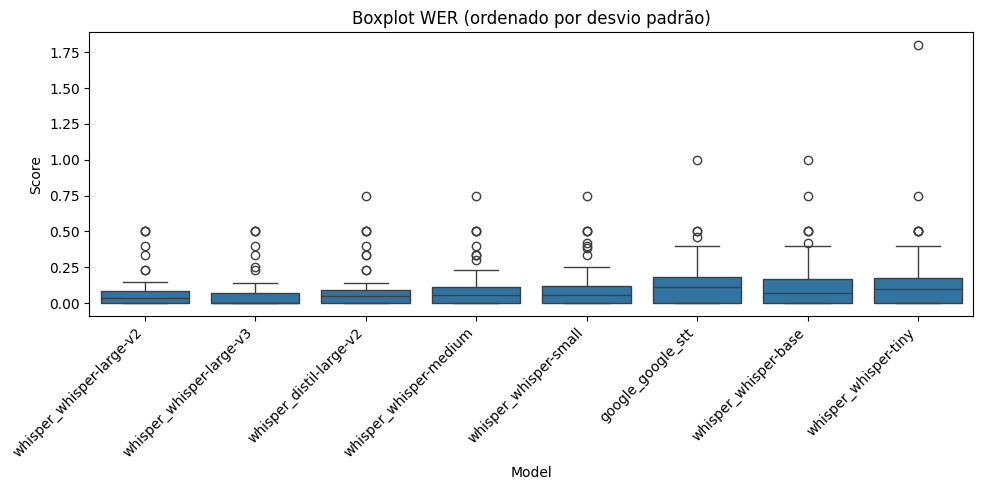

In [63]:

# Explodir dados
wer_data = df.explode("WER")[["Model", "WER"]].rename(columns={"WER": "Score"})

# Calcular desvio padrão
wer_std = wer_data.groupby("Model")["Score"].std().sort_values()

# Reordenar os modelos com base no desvio padrão
wer_data["Model"] = pd.Categorical(wer_data["Model"], categories=wer_std.index, ordered=True)

# Plot WER
plt.figure(figsize=(10, 5))
sns.boxplot(data=wer_data, x="Model", y="Score")
plt.title("Boxplot WER (ordenado por desvio padrão)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



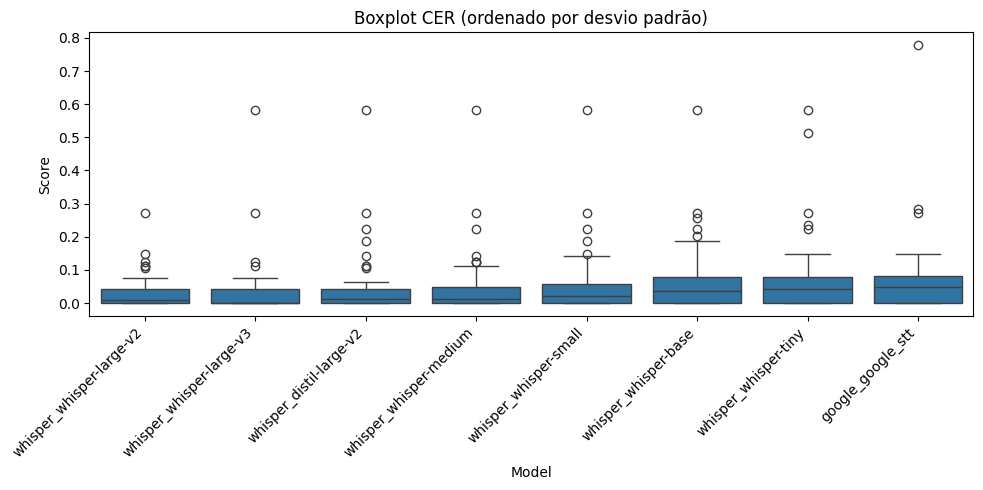

In [64]:

cer_data = df.explode("CER")[["Model", "CER"]].rename(columns={"CER": "Score"})
cer_std = cer_data.groupby("Model")["Score"].std().sort_values()
cer_data["Model"] = pd.Categorical(cer_data["Model"], categories=cer_std.index, ordered=True)
# Plot CER
plt.figure(figsize=(10, 5))
sns.boxplot(data=cer_data, x="Model", y="Score")
plt.title("Boxplot CER (ordenado por desvio padrão)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

- Outros datasets
- Mais testes no Whisper (frameworks, param...)
- Outros Modelos

In [ ]:

from datasets import load_dataset

dataset = load_dataset('hf-internal-testing/librispeech_asr_dummy')


Generating validation split: 100%|██████████| 73/73 [00:00<00:00, 2922.39 examples/s]


NameError: name 'i' is not defined

In [10]:
import glob
import pandas as pd
import os
results_dir = '/workspace/results_librispeech_asr_dummy'
i=10

print("Texto de referência:\n", dataset['validation']['text'][i])
print('-'*20)
for result in glob.glob(os.path.join(results_dir, "*.csv")):
    print(result.split('/')[-1].replace('.csv', ''))
    df = pd.read_csv(result)
    print(df.iloc[i].transcricao)
    print('-' * 20)

Texto de referência:
 NEAR THE FIRE AND THE ORNAMENTS FRED BROUGHT HOME FROM INDIA ON THE MANTEL BOARD
--------------------
whisper_whisper-tiny
 Near the fire, any ornaments Fred brought home from India on the mental board.
--------------------
whisper_whisper-medium
 near the fire, and the ornaments Fred brought home from India on the mental board.
--------------------
whisper_whisper-large-v2
 near the fire, and the ornaments Fred brought home from India on the mantelboard.
--------------------
api_whisper_whisper-1
Erro na transcrição: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
--------------------
google_google_stt
you're the fire and the ornaments Fred brought home from India on the mental board
--------------------


In [6]:
dataset['validation']['text']

['MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL',
 "NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER",
 'HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND',
 "HE HAS GRAVE DOUBTS WHETHER SIR FREDERICK LEIGHTON'S WORK IS REALLY GREEK AFTER ALL AND CAN DISCOVER IN IT BUT LITTLE OF ROCKY ITHACA",
 "LINNELL'S PICTURES ARE A SORT OF UP GUARDS AND AT EM PAINTINGS AND MASON'S EXQUISITE IDYLLS ARE AS NATIONAL AS A JINGO POEM MISTER BIRKET FOSTER'S LANDSCAPES SMILE AT ONE MUCH IN THE SAME WAY THAT MISTER CARKER USED TO FLASH HIS TEETH AND MISTER JOHN COLLIER GIVES HIS SITTER A CHEERFUL SLAP ON THE BACK BEFORE HE SAYS LIKE A SHAMPOOER IN A TURKISH BATH NEXT MAN",
 'IT IS OBVIOUSLY UNNECESSARY FOR US TO POINT OUT HOW LUMINOUS THESE CRITICISMS ARE HOW DELICATE IN EXPRESSION',
 'ON THE GENERAL PRINCIPLES OF ART MISTER Q